# HCC1806 Data Preprocessing

## Introduction
The structure of the file is the following:
1. EDA (Exploratory Data Analysis)
    * Metadata Files
    * Sequencing Data (HCC1806)
        * Description
        * Duplicates    
            * Cells correlation 
        * Sparsity and NANs
        * Labeling
        * Outliers
            * Boxplot
            * IQR
            * After Normalization  
        * Distribution
            * Histogram
            * (Density Plot)
            * Test for Normality
            * Test for other distributions
        * Correlation
            * More on cells correlation
            * Genes correlation
        * Transformations
        * Normalization

2. Dimensionality Reduction 
## Materials and Methods

## Libraries

We start checking for libraries that are needed

In [1]:
# Check for libraries that are needed
!pip install pandas
!pip install numpy==1.19.5
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy.stats
!pip install scanpy


  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1032 lines of output]
      setup.py:67: RuntimeWarning: NumPy 1.19.5 may not yet support Python 3.11.
        warnings.warn(
      Running from numpy source directory.
      Cythonizing sources
      numpy/random/_bounded_integers.pxd.in has not changed
      numpy/random/_philox.pyx has not changed
      numpy/random/_bounded_integers.pyx.in has not changed
      numpy/random/_sfc64.pyx has not changed
      numpy/random/_mt19937.pyx has not changed
      numpy/random/bit_generator.pyx has not changed
      Processing numpy/random/_bounded_integers.pyx
      numpy/random/mtrand.pyx has not changed
      numpy/random/_generator.pyx has not changed
      numpy/random/_pcg64.pyx 

In [2]:
# install additional packages
!pip install -q scanpy
!pip install -q scikit-misc
!pip install -q pyvis
!pip install -q leidenalg

We import libraries

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
import torch as th
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kstest
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import nbinom
from scipy.stats import gamma
from scipy.stats import chi2_contingency
import scipy.stats as stats
import random
from scipy.stats import mannwhitneyu
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import plotly

------------------------------------------------------------------------

------------------------------------------------------------------------

## EDA (Exploratory Data Analysis)
Now we start by loading the 4 dataset.
Each of them is from a single experiment, and each experiment is different because of the sequencing technique for the cells' RNA, and of the cells' environment.

### Metadata files
We start with the metadata files, one for each experiment. They are TSV files

We import the first dataset and look at its stucture

In [3]:
df_metaM_path = '../ai_lab/SmartSeq/MCF7_SmartS_MetaData.tsv'
df_metaM = pd.read_csv(df_metaM_path, delimiter='\t')
print("Dataframe dimensions:", df_metaM.shape)
print("Dataframe columns:", df_metaM.columns)

Dataframe dimensions: (383, 9)
Dataframe columns: Index(['Filename', 'Cell Line', 'Lane', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')


We start doing some manipulations to shape the dataset in the way we need it: we drop the first column "Filename" as it is not needed

In [4]:


df_metaM = df_metaM.drop(columns=['Filename'])
df_metaM.head()

,Cell Line,Lane,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,MCF7,output.STAR.1,A10,Hypo,72,S28,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,MCF7,output.STAR.1,A11,Hypo,72,S29,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,MCF7,output.STAR.1,A12,Hypo,72,S30,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,MCF7,output.STAR.1,A1,Norm,72,S1,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,MCF7,output.STAR.1,A2,Norm,72,S2,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


We import the second dataset and look at its structure

In [5]:
df_metaH_path = '../ai_lab/SmartSeq/HCC1806_SmartS_MetaData.tsv'
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')
print("Dataframe dimensions:", df_metaH.shape)
print("Dataframe columns:", df_metaH.columns)

Dataframe dimensions: (243, 9)
Dataframe columns: Index(['Filename', 'Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')


We display the first 5 rows of our dataframe to take a closer look at the structure

In [6]:
df_metaH.head()

,Filename,Cell Line,PCR Plate,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...,HCC1806,1,A10,Normo,24,S123,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....,HCC1806,1,A12,Normo,24,S26,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...,HCC1806,1,A1,Hypo,24,S97,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...,HCC1806,1,A2,Hypo,24,S104,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...,HCC1806,1,A3,Hypo,24,S4,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


## What is the dataset made of?

For every row, we have a single observation from an experiment, and of course in the columns we have the collected data of the experiment. In order:
#### 1.  Cell Line 
  Content

#### 2. Lane
  Content

#### 3. Pos
  Content

#### 4. Condition
  Content

#### 5. Hours
  Content

#### 6. Cell Name
  Content

#### 7. Preprocessing Tag
  Content
  
#### 8. ProcessingComments
  Content


Condition
Hypo     126
Normo    117
Name: count, dtype: int64


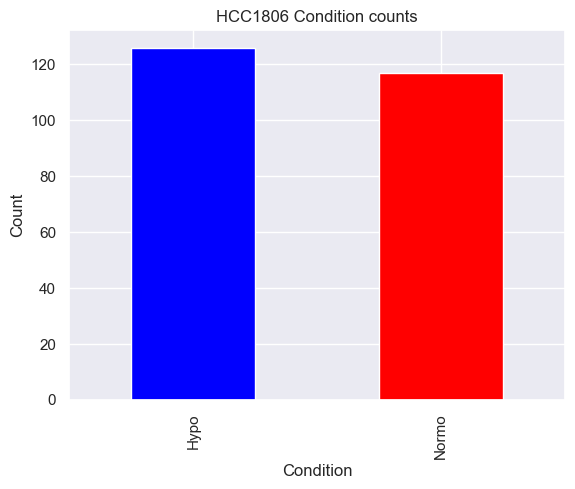

In [7]:
# before starting the analysis of seqdata we check the counts for Norm or Hypo
# in the column 'Condition' for both the datasets count the number of Norm and Hypo
counts = df_metaH['Condition'].value_counts()
# Histogram of the counts
print(counts)
# Plot the histogram with two columns for each condition
counts.plot(kind='bar', color=['blue', 'red'])
plt.title('HCC1806 Condition counts')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()


They have similar count so we can proceed with the analysis.

## Sequencing data

Now we go to sequencing data, and we notice that they are space-delimited.
Here we just create the path and the dataset on Python.
 


In [8]:
#We just create the path and the dataset on Python
df_seq_pathHFilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Data.txt'

df_seq_pathHFiltNorm = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathHUnfilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt'

df_seq_pathMFilt = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Data.txt'

df_seq_pathMFiltNorm = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathMUnfilt = '../ai_lab/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt'

df_seq_HFilt = pd.read_csv(df_seq_pathHFilt, delimiter=' ')

df_seq_HFiltNorm = pd.read_csv(df_seq_pathHFiltNorm, delimiter=' ')

df_seq_HUnfilt = pd.read_csv(df_seq_pathHUnfilt, delimiter=' ')

df_seq_MFilt = pd.read_csv(df_seq_pathMFilt, delimiter=' ')

df_seq_MFiltNorm = pd.read_csv(df_seq_pathMFiltNorm, delimiter=' ')

df_seq_MUnfilt = pd.read_csv(df_seq_pathMUnfilt, delimiter=' ')

There are six dataset, and we can understand what they actually are based on their name, for the EDA part we focus on the Unfiltered datased but then we will use Filtered and Normalised one for supervised/uns ML.

#### 1. SmartSeq\HCC1806_SmartS_Unfiltered_Data.txt
  The cell line is HCC1806, the technology is SmartS, and this dataset contains the Unfiltered data

#### 2. SmartSeq\MCF7_SmartS_Unfiltered_Data.txt
  The cell line is MCF7, the technology is SmartS, and this dataset contains the Unfiltered data



We analyze one dataset at a time.

#### 1. SmartSeq\HCC1806_SmartS_Unfiltered_Data.txt

We take a closer look at the dataframe for the unfiltred data and we see in particular that the features are on the rows so we understand that we are going to need to transpose the data matrix at some point during our research

In [9]:
# Exploring the dataframe for the unfiltered data
print("Dataframe dimension:", df_seq_HUnfilt.shape)
print("First Column:", df_seq_HUnfilt.iloc[:,0])
print("Columns list:", list(df_seq_HUnfilt.columns))
# Hence we see features on the rows and therefore we need to transpose the data matrix

Dataframe dimension: (23396, 243)
First Column: WASH7P         0
CICP27         0
DDX11L17       0
WASH9P         0
OR4F29         2
            ... 
MT-TE         22
MT-CYB      4208
MT-TT         26
MT-TP         66
MAFIP          0
Name: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam, Length: 23396, dtype: int64
Columns list: ['output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPl

In [10]:
# Check for the types of data in the dataframe
print("Data types in the dataframe:", df_seq_HUnfilt.dtypes)
# Check for features
gene_symbols = df_seq_HUnfilt.index
print("Gene symbols in the dataframe:",gene_symbols)

Data types in the dataframe: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       int64
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        int64
                                                                        ...  
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     int64
Length: 243, dtype: object
Gene symbols in the dataframe: Index(['WASH7P', 'CICP27', 'DDX11L17', 'WASH9P', 'OR4F2

Here we take the transpose of our dataframe

In [11]:
# Take the transpose of the dataframe
print("Dataframe dimension before transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt = df_seq_HUnfilt.T
print("Dataframe dimension after transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt.head(5)


Dataframe dimension before transpose: (23396, 243)
Dataframe dimension after transpose: (243, 23396)


,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,17,5,15,3852,900,22,4208,26,66,0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,49,29,36,7457,1439,43,6491,62,71,4
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,0,93,12,0,25,0,1,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,43,17,8,1479,234,0,4819,11,3,7
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,0,3,303,33,0,310,4,9,0


Here we just look for missing values in our dataframe

In [ ]:
# Now we look at evetual missing values in the dataframe
print("Missing values in the dataframe by columns:", df_seq_HUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_HUnfilt.isna().sum().sum())

Now we generate descriptive statistics for the DataFrame df_seq_HUnfilt

In [ ]:
df_seq_HUnfilt.describe()

We add the column 'Filename' to the dataframe df.metah in order to merge it based on this common column with df_seq_HUnfilt

In [13]:
# Now we want to add the target column (i.e. the class) to the dataframe, we get the condition from metadata
print(df_metaH.columns)
df_metaH.set_index('Filename', inplace=True)
# Merge the two dataframes with key 'Filename'
merged_df = pd.merge(df_seq_HUnfilt, df_metaH['Condition'], left_index=True, right_index=True)
print(merged_df.columns)

Index(['Filename', 'Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')
Index(['WASH7P', 'CICP27', 'DDX11L17', 'WASH9P', 'OR4F29', 'MTND1P23',
       'MTND2P28', 'MTCO1P12', 'MTCO2P12', 'MTATP8P1',
       ...
       'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB', 'MT-TT',
       'MT-TP', 'MAFIP', 'Condition'],
      dtype='object', length=23397)


Now transform the categorical variable 'Condition' to numerical 

In [14]:
# Now transform the categorical variable 'Condition' to numerical
dummy_variables = pd.get_dummies(merged_df['Condition'], prefix='category').astype('int')
merged = pd.concat([merged_df, dummy_variables], axis=1)
print(merged.head())
merged.drop(columns=['category_Hypo', 'Condition'], inplace=True)
merged.rename(columns={'category_Normo': 'Target'}, inplace=True)
# Note that 1 = Hypo, 0 = Norm

                                                    WASH7P  CICP27  DDX11L17  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....       0       0         0   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...       0       0         0   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...       0       0         0   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...       0       0         0   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...       0       0         0   

                                                    WASH9P  OR4F29  MTND1P23  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....       0       2       250   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...       0       0       424   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...       0       0        11   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...       0       0        63   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...       0       0        27   

                                      

We take a lot at the dataframe again showing 5 rows

In [15]:
merged.head()

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,Target
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,5,15,3852,900,22,4208,26,66,0,1
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,29,36,7457,1439,43,6491,62,71,4,1
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,93,12,0,25,0,1,0,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,17,8,1479,234,0,4819,11,3,7,0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,3,303,33,0,310,4,9,0,0


We now look for:
1. Duplicates
2. Sparsity
3. NaNs
4. Outliers
5. Distributions
6. Correlation
7. Normalization

We now start analyzing the data. 
First we look for duplicates.

In [12]:
# Check for duplicates
print("Number of duplicates in the dataframe:", merged.duplicated().sum())
# we will now check for duplicates in a broader sense, by checking for observations with high correlation
# we start by computing the correlation matrix of the observations
merged_t = merged.T
correlation_matrix_transpose = merged_t.corr()
correlation_matrix_transpose

NameError: name 'merged' is not defined

In [ ]:
# now we will check for observations with high correlation and drop them
columns_to_keep = []

def add_representative(corr_matrix, col, threshold=0.95):
    corr = corr_matrix[col].drop(col)
    max_corr_id = corr.idxmax()
    max_corr = corr[max_corr_id]
    if max_corr < threshold:
        columns_to_keep.append(col)
        return None
    else:
        if (col not in columns_to_keep) and (max_corr_id not in columns_to_keep):
            columns_to_keep.append(col)
            print('choosing %s as representative for %s with correlation %s' % (col, max_corr_id, max_corr))
            return None
        


for col in merged_t:
    add_representative(correlation_matrix_transpose, col, 0.95)

dropped_cols = [col for col in merged_t if col not in columns_to_keep]

merged_uncorr_obs = merged_t[columns_to_keep].T
print('dropped %s observations' % str(len(dropped_cols)))
merged_uncorr_obs

Now we look at the sparsity of the model. In particular we calculate this value as the percentage of missing values.

In [ ]:
# Check for sparsity
total_elements = merged.shape[0] * merged.shape[1]
print("Total number of elements in the DataFrame:", total_elements)
missing_values = (merged == 0).sum().sum()
print("Total number of missing values in the DataFrame:", missing_values)
# Calculate the sparsity as the percentage of missing values
sparsity = (missing_values / total_elements) * 100
print("Sparsity of the DataFrame: {:.2f}%".format(sparsity))

Now we want to visualize the sparsity of our model. 
In order to do so we create a binary DataFrame indicating missing values (1 for missing, 0 for not missing) and we select the color white for the missing ones and red for not missing ones.
Then we create the heatmap, add a title and labels with custom font size and style and remove the plot's spines (borders) for a cleaner appearance.

In [ ]:
# Visualization of sparsity
# Assuming merged is your DataFrame

# Create a binary DataFrame indicating missing values (1 for missing, 0 for not missing)
missing_mask = merged == 0

# Set up a custom color palette
colors = ["#FFFFFF", "#FF6347"]  # White for non-missing, red for missing

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_mask, cmap=sns.color_palette(colors), cbar=False, xticklabels=False, yticklabels=False)

# Add title and labels with custom font size and style
plt.title('Sparsity Pattern of the DataFrame', fontsize=18, fontweight='bold')
plt.xlabel('Genes', fontsize=14)
plt.ylabel('Observations', fontsize=14)



# Remove the spines (borders) of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


DA AGGIUNGERE PACO

We now check for the number of NaN values in the dataframe

In [ ]:
# Check for NaN values
print("Number of NaN values in the DataFrame:", merged.isna().sum().sum())

We now look for outliers. 
We use different tecniques.
The first one is with boxplots
So we create a set of 5 boxplots, each depicting the distribution of gene expression counts for a randomly selected subset of genes from the merged DataFrame. 


Outliers for dataset with rows as cells and columns as genes

In [ ]:
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 5

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)


plt.figure(figsize=(12, 8))  
for i, column in enumerate(random_columns):
    plt.subplot(1, len(random_columns), i+1)
    
    # Customizing boxplot appearance
    sns.boxplot(y=merged[column], color='skyblue', width=0.5)
    
    # Overlaying swarmplot for better visualization of individual data points
    sns.swarmplot(y=merged[column], color='red', alpha=0.5)
    
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel('Count of the gene expression', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)


plt.tight_layout()
plt.show()

Secondly we use the Inter-Quartile Range (IQR) proximity rule for each column.
We start calculating the first and third quartiles along with the IQR for each column in the DataFrame merged. We then identifie outliers based on the IQR proximity rule and print both the number of outliers in each column and the percentage of outliers in the entire DataFrame.

In [ ]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
outliers = (merged < (Q1 - 1.5 * IQR)) | (merged > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

As third approach we normalize each column independently and find the outliers of the flattened array

In [ ]:
# now we normalize each column independently
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_df_normalized = merged[merged.columns[:-1]].copy()
features_df_normalized[features_df_normalized.columns] = scaler.fit_transform(features_df_normalized[features_df_normalized.columns])
features_df_normalized.describe()

In [ ]:
# convert the dataframe to a numpy array, find outliers
features_array_normalized = np.array(features_df_normalized.T)
# still need to find the outliers
fig = plt.figure(figsize=(10, 7))
plt.boxplot(features_array_normalized.flatten())
# here, we notice that most of the data are outliers

Now we are interested in discovering if the number of times a gene is expressed is generated by some known distribution.

In order to do so, we start having a look at the distribution by plotting histograms with the frequencies of number of expressions for 5 random genes, with their kernel densities.

By doing this, we immediately notice that the distributions are highly asymmetrical.

In [ ]:
#visualize the distribution of the data through histograms
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 6

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)



fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    sns.histplot(merged[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()



to check this asymmetry, we compute the skewness of these distributions for all the genes.

Skewness is ***a measure of symmetry***, or more precisely, the lack of symmetry.

We obtain that all the skewness are positive. This means that the distribution is characterised by a tail stretching right, as we could already say from the first histograms.

In [ ]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_values)

We now want to visualize this values we found.
In order to do so we utilize an histogram with as refererence the rounded skewness values.

In [ ]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged.skew()

# Round the skewness values
rounded_skewness_values = np.round(skewness_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewness_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

we proceed the analysis of the shape of the distribution by computing the kurtosis.

Kurtosis measures the peakedness or flatness of a distribution relative to a normal distribution. A positive kurtosis indicates a relatively peaked distribution (leptokurtic), while a negative kurtosis indicates a flatter distribution (platykurtic) compared to a normal distribution.

Also in this case, we get positive values, which suggest heavier tails and a more peaked distribution.

These informations on skewness and kurtosis suggest that the distributions are not normal.

In [ ]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_values)

We want to visualize this value as well.
Again we proceed creating a histogram using as data the rounded kurtosis values of our dataframe

In [ ]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged.kurtosis()

# Round the kurtosis values
rounded_kurtosis_values = np.round(kurtosis_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosis_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The analysis of the distribution of our dataframe goes on.
To check the non-normality mathematically we run the Kolmogorov-Smirnov test, a statistic tool commonly used to check if a distribution is not normal.

we proceed with the following hypothesis testing:

H0: our distribution is normal

H1: not normal.

Setting our p value threshold at 0.05, we have statistically significant evidence that none of our feature is normally distributed.

We then count how many features according to this test have non-normal distribution and we find out that this a common characteristic of all the features.

In [ ]:
# Test the distribution of the data matrix using Kolmogorov-Smirnov
# Test normality of each feature
def test_distribution_per_feature(data):
    non_normal_count = 0
    for column in data.columns:
        p_value = kstest(data[column], 'norm')[1]
        if p_value < 0.05:
            non_normal_count += 1
    print("Number of features with non-normal distribution:", non_normal_count)
    if data.shape[1] == non_normal_count:
        print("All features have non-normal distribution")
    else:
        print("Not all features have non-normal distribution")
    return non_normal_count

non_normal_count = test_distribution_per_feature(merged)


Some distribution commonly found in nature are also the poisson one and the negative binomial one. For this reason we want to check this ones too

Before checking mathematically if it’s plausible to assume some distributions, we have to introduce the chi squared test.

The chi-square goodness-of-fit test is used to determine if a sample of categorical data follows a specific distribution, such as a normal distribution or any other expected distribution. It compares the observed frequencies of the categories with the frequencies that would be expected if the data followed the specified distribution. If the difference between the observed and expected frequencies is sufficiently large, it suggests that the data may not follow the expected distribution.

We run such test to see if we can exclude the poisson distribution. 

To do so we estimate the parameter lamba with the estimator lambda. Then we create random samples from a poisson distribution with such lambda, and we run the test.

If some features pass this test, we don’t have the guarantee that they are poisson, but we can check it by plotting the histogram and the qq plot.

From our test we see that there are 3156 columns that could be poisson distributed.

To see if they actually are we plot 3 of them and we actually see that they really might me poisson.

In [ ]:
# Iterate over columns and perform the test
def test_poissondistribution_per_feature(data):
    poisson_list = [] # initialize list to store features with Poisson distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the Poisson distribution)
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(poisson.pmf(value, mean) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a Poisson distribution
        if p >= 0.05:
            poisson_list.append(column)
    print("Number of features that might have poisson distribution:", len(poisson_list))
    if len(poisson_list) == 0:
        print("All features have non-poisson distribution")
    else:
        print("Some features might have poisson distribution")
    return poisson_list

poisson_columns = test_poissondistribution_per_feature(merged)

In [ ]:
# now we plot the hist of the poisson columns
#now we visualize the empirical distribution against the Gamma distribution for some columns
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(poisson_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    mean = observed_values.mean()
    poisson_values = np.random.poisson(mean, len(observed_values))
    
    stats.probplot(observed_values, dist='poisson', sparams=(mean,), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(poisson_values, kde=True, color='red', label='Gamma', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

We now do exactly the same for the negative binomial distribution.

In [ ]:
# Iterate over columns and perform the test
def test_negative_binomial_distribution_per_feature(data):
    nbin_list = [] # initialize list to store features with Gamma distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
        var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
        size = mean ** 2 / (var - mean) # size parameter of the nbinom distribution
        prob = 1 - (mean/var) # probability parameter of the nbinom distribution
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(nbinom.pmf(value, size, prob) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a negative binomial distribution
        if p >= 0.05:
            nbin_list.append(column)
    print("Number of features with Negative Binomial distribution:", len(nbin_list))
    if len(nbin_list) == 0:
        print("All features have non-Negative Binomial distribution")
    else:
        print("Some features might have Negative Binomial distribution")
    return nbin_list

negative_binomial_columns = test_negative_binomial_distribution_per_feature(merged)

In [ ]:
# now we plot the hist of the nbin columns
#now we visualize the empirical distribution against the negative binomial distribution for some columns

np.random.seed(100)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(negative_binomial_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
    var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
    # HERE WE ARE CHEATING WITH THE ABSOLUTE VALUE AND THE "NORMALIZATION" OF THE PROB
    size = abs(mean ** 2 / (var - mean)) # size parameter of the nbinom distribution
    prob = 1 - (mean/var) # probability parameter of the nbinom distribution
    if prob < 0:
        prob = 0
    elif prob > 1:
        prob = 1


    stats.probplot(observed_values, dist='nbinom', sparams=(size,prob), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    plt.title(f'QQ-plot of {column}', fontsize=12)
    nbinom_values = np.random.negative_binomial(size, prob, len(observed_values))
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(nbinom_values, kde=True, color='red', label='Negative Binomial', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# from scipy.stats import gamma

# def test_gamma_distribution_per_feature(data):
#     non_gamma_count = 0
#     for column in data.columns:
#         observed_values = data[column].values  # Observed counts from your data
#         shape, loc, scale = gamma.fit(observed_values)
#         expected_values = gamma.pdf(observed_values, shape, loc, scale) * len(observed_values)
#         expected_values += 1e-10  # Adjust this value if needed

#         contingency_table = [[observed_values[i], expected_values[i]] for i in range(len(observed_values))]

#         chi2, p, _, _ = chi2_contingency(contingency_table)
        
#         # Check if the p-value is less than the significance level
#         if p < 0.05:
#             non_gamma_count += 1
    
#     print("Number of features with non-gamma distribution:", non_gamma_count)

#     if data.shape[1] == non_gamma_count:
#         print("All features have non-gamma distribution")
#     else:
#         print("Not all features have non-gamma distribution")
        
#     return non_gamma_count

# test_gamma_distribution_per_feature(merged)

# # eventually run this and maybe also plot it

What we can check is that, under some specific condition (i.e. hypoxia), the genes could have some distribution (that maybe we can’t observe in the mixed case). 

So we go through the exact same process for for the genes under hypoxia and normoxia separately.

In [ ]:
#now we check the distribution but for hypoxia and normoxia separtely
merged_norm = merged[merged['Target'] == 0]
merged_hypo = merged[merged['Target'] == 1]

In [ ]:
print("Number of normoxia samples:", merged_norm.shape[0])
test_distribution_per_feature(merged_norm)
print("Number of hypoxia samples:", merged_hypo.shape[0])
test_distribution_per_feature(merged_hypo)

In [ ]:
print("Number of normoxia samples:", merged_norm.shape[0])
test_negative_binomial_distribution_per_feature(merged_norm)
print("Number of hypoxia samples:", merged_hypo.shape[0])
test_negative_binomial_distribution_per_feature(merged_hypo)

We now take a look at the correlation.
we already inspected the one between cells during the duplicates inspection, so now we procced looking at the one between genes.
We do so by calculating the correlation matrix. 

In [ ]:
# We will use pytorch correlation matrix to calculate the correlation matrix usint torch.corrcoef
# Correlation matrix between the genes (features)

# Convert the DataFrame to a PyTorch tensor
data_tensor = th.tensor(merged.values).T
# Calculate the correlation matrix
correlation_matrix = th.corrcoef(data_tensor)
print(correlation_matrix)
# Nicely visuaize the correlation matrix
# plt.figure(figsize=(12,10))
# sns.heatmap(correlation_matrix, cmap='coolwarm', yticklabels = False, xticklabels = False)
# plt.xlabel('Sample')
# plt.ylabel('Sample')
# plt.show()

# Compute the midpoint
midpoint = (correlation_matrix.max() - correlation_matrix.min()) / 2 + correlation_matrix.min()
# Print the size of the correlation matrix
print("Size of the correlation matrix: ", correlation_matrix.shape)
# Print average and minimum correlation values
print("Average correlation between cells: ", float(midpoint))
print("Minimum correlation between cells: ", float(correlation_matrix.min()), "\n")

here we come back to inspect the correlation between cells.
In particular, we procced analysing the cells in the dataset with the lowest correlation with other cells, retrieve their names and plot histograms of their expression values.

In [ ]:
# We can see from the minimum value obtained that there are some cells that are 
# completely uncorrelated from the others and we want to see why
# Find the indices of the minimum value in the correlation matrix
data_tensor_transpose = data_tensor.T
print(data_tensor_transpose.shape)
correlation_matrix_transpose = th.corrcoef(data_tensor_transpose)
print(correlation_matrix_transpose.shape)
min_indices = th.where(correlation_matrix_transpose == correlation_matrix_transpose.min())
print("Indices of the minimum value in the correlation matrix: ", min_indices)
# Transform min_indices to a list
value1 = min_indices[0].item()
value2 = min_indices[1].item()
# Access rows with index value1 and value2
cells_identified = merged.iloc[[value1, value2]]
print(f"Cell names with minimum correlation: {cells_identified.index[0]}, {cells_identified.index[1]}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(data_tensor_transpose[min_indices[0]], bins=20, color='skyblue', edgecolor='black')
# set title with corresponding cell index

axs[0].set_title(f'Histogram of Cell: \n{cells_identified.index[0]}', fontsize=12)
axs[0].set_xlabel('Expression Value', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[1].hist(data_tensor_transpose[min_indices[1]], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title(f'Histogram of Cell: \n{cells_identified.index[0]}', fontsize=12)
axs[1].set_xlabel('Expression Value', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

we proceed plottinf the two types of correlation we looked at using histograms.

In [ ]:
# Correlation between cells (samples)
# Plot histogram of the values to see the distribution
data_tensor = th.tensor(merged.values)
correlation_matrix_transpose = th.corrcoef(data_tensor)
plt.figure(figsize=(10, 6))
sns.histplot(correlation_matrix_transpose.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values', fontsize=16)
plt.xlabel('Correlation Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Clear that we have peaks at high correlation values between cells. In principle, this is explained by the fact that every 
# gene expression in the table is coming from the same cell line we expect overall an high correlation among them.

In [ ]:
# We now can plot the distribution of the correlation between gene expression profiles using a 
# histogram (we do it on the first ten variables)

correlation_matrix = pd.DataFrame(correlation_matrix_transpose)
print(correlation_matrix.shape)
c_subset = correlation_matrix.iloc[:,:10]
sns.histplot(c_subset,bins=100)
plt.legend().set_visible(False)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')
plt.plot()


we are now insterested in seeing if the correlation between the cells is different between the two classes hypoxia and normoxia. 
We can do this by plotting the correlation matrix for each class separately.
We can do this by splitting the dataframe into two dataframes, one for each class.

In [ ]:

# Convert the DataFrames to PyTorch tensors
data_tensor_norm = th.tensor(merged_norm.values)
data_tensor_hypo = th.tensor(merged_hypo.values)

# Calculate the correlation matrices
correlation_matrix_norm = th.corrcoef(data_tensor_norm)
correlation_matrix_hypo = th.corrcoef(data_tensor_hypo)

# Plot the correlation matrices with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(correlation_matrix_norm, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[0], square=True)
sns.heatmap(correlation_matrix_hypo, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[1], square=True)
# Set titles with number of genes that are norm or hypo
axs[0].set_title(f'Normoxia ({merged_norm.shape[0]} cells)')
axs[1].set_title(f'Hypoxia ({merged_hypo.shape[0]} cells)')
plt.show() 

# Check shape of correlation matrices
print("Shape of correlation matrix for normoxia:", correlation_matrix_norm.shape)
print("Shape of correlation matrix for hypoxia:", correlation_matrix_hypo.shape)

________________________________________________________________________________________________________________________
We are now interested in doing the same data analysis that we did for the trasposed dataset for the original dataset.

In [ ]:
# we simply transpose again the dataframe (now we have cells as columns)
print("Dataframe dimension before transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt = df_seq_HUnfilt.T
print("Dataframe dimension after transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt.head(5)

In [ ]:

print("Missing values in the dataframe by columns:", df_seq_HUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_HUnfilt.isna().sum().sum())

In [ ]:
df_seq_HUnfilt.describe()

In [ ]:
# Just renaming
mergedT = df_seq_HUnfilt

Outliers for the transpose dataset (rows are genes)

In [ ]:
# # TO REVIEW
# np.random.seed(42)

# # Number of boxplots you want to create
# num_boxplots = 5

# # Randomly select column indices
# random_columns = np.random.choice(mergedT.columns[1:], num_boxplots, replace=False)


# plt.figure(figsize=(12, 8))  
# for i, column in enumerate(random_columns):
#     plt.subplot(1, len(random_columns), i+1)
    
#     # Customizing boxplot appearance
#     sns.boxplot(y=mergedT[column], color='skyblue', width=0.5)
    
#     # Overlaying swarmplot for better visualization of individual data points
#     sns.swarmplot(y=mergedT[column], color='red', alpha=0.5)
    
#     plt.title(f'Boxplot of {column}', fontsize=14)
#     plt.ylabel('Count of the gene expression', fontsize=12)
#     plt.xlabel('', fontsize=12)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.grid(True)


# plt.tight_layout()
# plt.show()

In [ ]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = mergedT.quantile(0.25)
Q3 = mergedT.quantile(0.75)
IQR = Q3 - Q1
outliers = (mergedT < (Q1 - 1.5 * IQR)) | (mergedT > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

In [ ]:
# edo

Now we analyze distribution of the transpose dataset (rows are genes) in the same way we did before.

In [ ]:
#visualize the distribution of the data through histograms
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(mergedT.columns[1:], num_boxplots, replace=False)



fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    sns.histplot(mergedT[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    # rescale the y-axis to better visualize the distribution
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_valuesT)

In [ ]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT.skew()

# Round the skewness values
rounded_skewnessT_values = np.round(skewness_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewnessT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_valuesT)

In [ ]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT.kurtosis()

# Round the kurtosis values
rounded_kurtosisT_values = np.round(kurtosis_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosisT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Test normality using the Kolmogorov-Smirnov test impl. before
non_normal_countT = test_distribution_per_feature(mergedT)

In [ ]:
# Now test other distribition in the same way
test_poissondistribution_per_feature(mergedT)

In [ ]:
test_negative_binomial_distribution_per_feature(mergedT)

In [ ]:
# test_gamma_distribution_per_feature(mergedT)

In [ ]:
# DA AGGIUNGERE REPR FOR GAMMA

________________________________________________________________________________________________________________________

Now that we finished the analysis of the data we proceed with the normalization.
In order to do so, we will work on the transpose dataset (genes as rows and cells as columns)

In [ ]:
mergedT.shape

since we have an highly non normal distributed data we try to take different concave transformations and then check which one is the best.
the first transformation we use is a squarw root with a random index to pick a single feature from the transposed dataset for the analysis.

In [ ]:
# Highly non normal distribution hence we take concave transformations the features
# Inspect first a single randomly selected feature

# we are using the transposed dataset

# Select a random index with seed
np.random.seed(42)
randomindex = np.random.randint(0, mergedT.shape[1])

# Apply the square root of the feature with random index
mergedT_squareroot = np.sqrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_squareroot)
axs[1].set_title("Square Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

the second transformation is the cubic root.

In [ ]:
mergedT_cuberoot = np.cbrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_cuberoot)
axs[1].set_title("Cube Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

the last transformation is the logarithm.

In [ ]:
mergedT_log2_onecol = np.log2(mergedT[mergedT.columns[randomindex]]+1)
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_log2_onecol)
axs[1].set_title("Log data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

We now show that between the transformation we tryed the best one is the log one.
In order to do so we look at the skewness of the transformed data and then plot the histograms to inspect why the skewness is negative. Finally we procced plotting the density of the transformed columns.

In [ ]:
# Prove that log transformation is the best
# Calculate the skewness of the raw data
skewness_raw = mergedT[mergedT.columns[randomindex]].skew()
# Calculate the skewness of the log transformed data
skewness_log = np.log2(mergedT[mergedT.columns[randomindex]]+1).skew()
# Calculate the skewness of the square root transformed data
skewness_sqrt = np.sqrt(mergedT[mergedT.columns[randomindex]]).skew()
# Calculate the skewness of the cube root transformed data
skewness_cbrt = np.cbrt(mergedT[mergedT.columns[randomindex]]).skew()
# Print the skewness values
print(f"Skewness of raw data: {skewness_raw}")
print(f"Skewness of log transformed data: {skewness_log}")
print(f"Skewness of square root transformed data: {skewness_sqrt}")
print(f"Skewness of cube root transformed data: {skewness_cbrt}")

# Plot the histogram of transformed column, inspect why the skewness is negative
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Histogram for one column")
axs[0].hist(mergedT[mergedT.columns[randomindex]], bins = 100)
# Set x-axis limit
axs[0].set_xlim(0, 1000)
axs[0].set_title("Raw data")
axs[0].grid(True)
axs[1].hist(mergedT_log2_onecol)
axs[1].set_title("Log data")
axs[1].grid(True)

# Plot the density of the transformed column
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Density plot for one column")
sns.kdeplot(mergedT[mergedT.columns[randomindex]], ax=axs[0])
axs[0].set_title("Raw data")
axs[0].grid(True)
sns.kdeplot(mergedT_log2_onecol, ax=axs[1])
axs[1].set_title("Log data")
axs[1].grid(True)


now we plot the densities of 10 randomly selected features all in one plot with sns with rescaled x axis

In [ ]:
np.random.seed(42)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot for 10 columns")
for i in np.random.randint(0, mergedT.shape[1], 10):
    np.log2(mergedT[mergedT.columns[i]]+1).plot.density(legend = False)
ax.set_title("Raw data")
# Rescale x limits
ax.set_xlim(-10, 20)
plt.grid(True)
ax.grid(True)
plt.show()



DA CAMBIARE What can we say about these results? We see that there are two peaks, so close to half of the genes are usually not expressed (or very low expressed) while roughly the other half is very expressed. So, this indicates the presence of two subgroups of genes for each cell. In classification, we want to "compare" these distributions, but from the boxplot above, we can see that different samples have different expression levels range, which complicates the task!

Now that we saw that the log transformation is the best for this randomly selected random feature, we proceed inspecting the whole dataset.
So we apply the three transformations to the whole dataset and we check which one is the best by analyzing the skewness and the kurtosis of the two resulting datasets.


In [ ]:
# Apply the log transformation to the entire dataset
mergedT_log = np.log2(mergedT+1)
mergedT_cbrt = np.cbrt(mergedT)
mergedT_sqrt = np.sqrt(mergedT)
# Convert to DataFrame
mergedT_log = pd.DataFrame(mergedT_log, columns=mergedT.columns, index=mergedT.index)
mergedT_cbrt = pd.DataFrame(mergedT_cbrt, columns=mergedT.columns, index=mergedT.index)
mergedT_sqrt = pd.DataFrame(mergedT_sqrt, columns=mergedT.columns, index=mergedT.index)
# Check skewness of the transformed data
skewness_log = mergedT_log.skew()
skewness_cbrt = mergedT_cbrt.skew()
skewness_sqrt = mergedT_sqrt.skew()
# Print the skewness values
print(f"Skewness of log transformed data: {skewness_log.mean()}")
print(f"Skewness of cube root transformed data: {skewness_cbrt.mean()}")
print(f"Skewness of square root transformed data: {skewness_sqrt.mean()}")
# Plot the histograms of the transformed data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("Histograms of transformed data")
axs[0].hist(mergedT_log.values.flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title("Log transformed data")
axs[1].hist(mergedT_cbrt.values.flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title("Cube root transformed data")
axs[2].hist(mergedT_sqrt.values.flatten(), bins=50, color='green', alpha=0.7)
axs[2].set_title("Square root transformed data")
plt.show()

Now that we saw that indeed the log transformation is the best we do some more plots on the data transformed in this way.

In [ ]:
# Create a list of skewness values for all columns
skewness_log = mergedT_log.skew()

# Now we histogram plot the skewness values for the log transformed data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Histogram of skewness values for log transformed data")
sns.histplot(skewness_log, bins=1000, color='blue')
ax.set_title("Log transformed data")
# Set x limits
ax.set_xlim(0, 2)
plt.grid(True)
plt.show()


In [ ]:
# kurtosis of log-trasnformed dataframe computed one column at a time
kurtosis_log = mergedT_log.kurtosis()
# Plot the histogram of kurtosis values
fig = plt.figure(figsize=(10,6))
plt.suptitle("Histogram of kurtosis values for log transformed data")
sns.histplot(kurtosis_log, bins=1000, color='blue')
plt.title("Log transformed data")
plt.xlim(0, 10)
plt.grid(True)
plt.show()

We use CPM (Counts Per Million) normalization, which is a common normalization technique for RNA-seq data. It is calculated as follows:
CPM values are calculated by dividing the number of reads mapped to a gene by a million scaling factor divided by the total of mapped reads.
We will do it across columns (i.e. across cells) because we want the genes' reads to be "normalized" and so comparable across different observations

In [ ]:
# CPM Normalization with a for loop
# Initialize a new DataFrame
mergedT_cpm = pd.DataFrame()
# Loop over each column
for column in mergedT.columns:
    # Calculate the CPM
    cpm = mergedT[column] / mergedT[column].sum() * 1e6
    # Add the CPM to the new DataFrame
    mergedT_cpm = pd.concat([mergedT_cpm, cpm], axis=1)


In [ ]:
mergedT_cpm.shape

In [ ]:
mergedT_cpm.head()

In [ ]:
mergedT_cpm.describe()

Here we boxplot our CPM-normalized cells. The distribution start to look balanced.

In [ ]:
#box-plot of log-transformed 50 random columns of dataframe
random_columns = list(range(0, mergedT.shape[1])) # list of integers from 1 to 243
random.shuffle(random_columns)
random_columns = random_columns[:50]
normalized_small = mergedT_cpm.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=normalized_small,palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);


Here we see that the Skeweness and Kurtosis values are still very high.The log transformation will definitely improve the symmetry of the distributions.

In [ ]:
# Check again skewness and kurtosis of the CPM normalized data
skewness_cpm = mergedT_cpm.skew()
kurtosis_cpm = mergedT_cpm.kurtosis()
# Print the skewness and kurtosis values
print(f"Mean Skewness of CPM normalized data: {skewness_cpm.mean()}")
print(f"Mean Kurtosis of CPM normalized data: {kurtosis_cpm.mean()}")
# boxplot of skewness
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle("Boxplot of CPM Normalized Data")
ax[0].boxplot(skewness_cpm)
ax[0].grid(True)
ax[0].set_title("Skewness")
ax[1].boxplot(kurtosis_cpm)
ax[1].grid(True)
ax[1].set_title("Kurtosis")
plt.show()


In [ ]:
# Now we will apply the log transformation to the CPM normalized data
mergedT_cpm_log = np.log2(mergedT_cpm+1)
# Convert to DataFrame
mergedT_cpm_log = pd.DataFrame(mergedT_cpm_log, columns=mergedT_cpm.columns, index=mergedT_cpm.index)

The boxplot of 10 random cells shows that the distributions after the log transformation are even more balanced and symmetric.

In [ ]:
# Study the distributions of 10 random columns now (boxplot and densities)
log_small = mergedT_cpm_log.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=log_small, palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);


Plotting the densities of 10 random cells, we notice a Bimodal distributions, with of course a peak at the 0, as we expected since most of the genes in each cell have 0 reading, and a second peak around 5, so this means that most of the genes, when they apprear, have a similar number of readings.

In [ ]:
# Densities of the 10 random columns
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot of 10 random columns")
for i in range(10):
    sns.kdeplot(mergedT_cpm_log.iloc[:, i], ax=ax)
ax.set_title("Log transformed CPM normalized data")
ax.set_xlabel("")
ax.grid(True)
plt.show()


In [ ]:
# from scipy.stats import beta

# # Iterate over columns and perform the test
# def test_beta_distribution_per_feature(data):
#     beta_list = [] # initialize list to store features with Gamma distribution
#     for column in data.columns:
#         observed_values = data[column].values  # values of the column
#         support = np.unique(observed_values) # unique values in the column
#         mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
#         var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
#         a = mean*(1/(1-mean))
#         b = mean*(1/var - 1/mean)
#         obs_freq = [] # initialize an empty array to store observed frequencies
#         for value in support:
#             obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
#         exp_freq = [] # initialize an empty array to store expected frequencies
#         for value in support:
#             exp_freq.append(beta.pdf(value,a,b) * len(observed_values)) # calculate the expected frequency for each unique value
#         # normalize the observed and expected frequencies
#         obs_freq = obs_freq / np.sum(obs_freq)
#         exp_freq = exp_freq / np.sum(exp_freq)
        
#         # perform the chi-square test
#         _, p = chisquare(obs_freq, exp_freq)
        
#         # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a beta distribution
#         if p >= 0.05:
#             beta_list.append(column)
#     print("Number of features with Beta distribution:", len(beta_list))
#     if len(beta_list) == 0:
#         print("All features have non-Beta distribution")
#     else:
#         print("Some features might have Beta distribution")
#     return beta_list

# beta_columns = test_beta_distribution_per_feature(mergedT_cpm_log)

________________________________________________________________________________________________________________________

## Feature Selection

In this section we try to find the genes that explain most of the variance, discarding all the others.So we want to remove these "undetectable" genes. How could we define a detectable gene? When there are biological replicates in each group, in this case, we have a sample size of 2 in each group. Therefore we could define a gene as detectable if there is a minimum counts-per-million (CPM) threshold in at least 2 samples.
Genes with very low counts in all samples provide
little evidence for differential expression.
We filter using CPM values rather than counts
because they account for differences in
sequencing depth between samples.
we could define a gene as detectable if there is a minimum counts-per-million threshold in at least 2 samples.
There is no general rule for choosing the threshold,
so we will do grid search for finding the optimal value.


In [ ]:
def filter_CPM(data, threshold):
    data_filtered = pd.DataFrame()
    # Keep track of the number of rows removed
    removed_genes = 0
    # Create a mask to filter out rows with low counts
    if 'Target' in data.index:
        data = data.drop('Target')
    mask_thr = data > threshold
    mask_rows = mask_thr.sum(axis=1) >= 2
    data_filtered = data.loc[mask_rows, :]
    return data_filtered

In [ ]:
filteredcpm = filter_CPM(mergedT_cpm_log, 0.5)
print(filteredcpm)
print("Number of rows before filtering:", mergedT_cpm_log.shape[0])

In [ ]:
# check if there is target column in the filtered data
print("Target column in the filtered data:", "Target" in mergedT_cpm_log.columns)
print("Target column in the filtered data:", "Target" in filteredcpm.columns)


In [ ]:
mergedT_cpm_log_transpose = mergedT_cpm_log.T

Technicality: the function discarded the 'Target' row, so we need to add it again

In [ ]:
# Now we want to add the target column (i.e. the class) to the dataframe, we get the condition from metadata
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')
print(df_metaH.columns)
df_metaH.set_index('Filename', inplace=True)
# Merge the two dataframes with key 'Filename'
merged_transition = pd.merge(mergedT_cpm_log_transpose, df_metaH['Condition'], left_index=True, right_index=True)

# Now transform the categorical variable 'Condition' to numerical
dummy_variables = pd.get_dummies(merged_transition['Condition'], prefix='category').astype('int')
merged_cpm_log = pd.concat([merged_transition, dummy_variables], axis=1)
print(merged_cpm_log.head())
merged_cpm_log.drop(columns=['category_Hypo', 'Condition'], inplace=True)
merged_cpm_log.rename(columns={'category_Normo': 'Target'}, inplace=True)
# Note that 1 = Hypo, 0 = Norm

In [ ]:
def add_target_column(data, metadata_path, target_column_name, target_category):
    df_meta = pd.read_csv(metadata_path, delimiter='\t')
    df_meta.set_index('Filename', inplace=True)
    merged_transition = pd.merge(data, df_meta[target_column_name], left_index=True, right_index=True)
    dummy_variables = pd.get_dummies(merged_transition[target_column_name], prefix='category').astype('int')
    
    # Set the target category to 1 and the others to 0
    dummy_variables['Target'] = dummy_variables[target_category]
    dummy_variables.drop(columns=[col for col in dummy_variables.columns if col != 'Target'], inplace=True)
    
    merged_data = pd.concat([merged_transition, dummy_variables], axis=1)
    merged_data.drop(columns=[target_column_name], inplace=True)
    return merged_data

add_target_column(mergedT_cpm_log_transpose, df_metaH_path, 'Condition', 'category_Normo')

In [ ]:
merged_cpm_log.shape

In [ ]:
# Split the dataset in Normo and Hypo based on Condition
normo_cpm_log = merged_cpm_log[merged_cpm_log["Target"] == 0]
hypo_cpm_log = merged_cpm_log[merged_cpm_log["Target"] == 1]

Since we have only two groups (Normoxia and Hypoxia), it could be useful to understand the significant genes to run the Wilcoxon Rank-Sum Test too.
In the Mann-Whitney test, the null hypothesis (usually denoted as 
states that there are no significant differences between the probability distributions of the two samples, meaning that both samples are drawn from the same population. 
The alternative hypothesis (usually denoted as  asserts that there is a significant difference between the distributions of the two samples, suggesting that one sample stochastically dominates the other.
So we run this test for each gene, and we store the corresponding p-values in a dictionary.


In [ ]:
# Wilcoxon rank-sum test 
# We will use the Wilcoxon rank-sum test to compare the distributions of two groups of samples.
def wilcoxon_ranksum_test(data):
    normo = data[data["Target"] == 0]
    hypo = data[data["Target"] == 1]
    p_values = {}
    for i in range(data.shape[1]):
        p_values[data.columns[i]] = mannwhitneyu(normo.iloc[:, i], hypo.iloc[:, i], alternative = "two-sided")[1]
    return p_values

p_values_mannwhitneyu = wilcoxon_ranksum_test(merged_cpm_log)
# print(p_values_mannwhitneyu)

Gene expression analysis involves comparing the expression levels of thousands of genes between different experimental conditions.
 Researchers typically conduct statistical testsfor each gene to determine if there are significant differences in expression between the conditions.

However, when performing thousands of statistical tests simultaneously, there's a high chance of observing false positives (genes incorrectly identified as differentially expressed) due to random chance alone. To address this issue, researchers use multiple testing corrections to control the false discovery rate (FDR).
Here's how q-values come into play: by  Benjamini-Hochberg procedure we adjusts the p-values to account for the number of tests performed and controls the FDR.
By using q-values, we can prioritize genes that are more likely to be truly differentially expressed while minimizing the number of false discoveries. 

In [ ]:
def q_value (p_val_dict):
  sorted_list = [[key, value] for (key, value) in sorted(p_val_dict.items(), key=lambda x: x[1])]
  rank = 1
  for p in sorted_list:
    p[1] = p[1] * len(p_val_dict)/rank
    rank += 1
  q_val_dict = dict(sorted_list)
  q_val_dict = (sorted(q_val_dict.items()))
  return q_val_dict

In [ ]:
q_value(p_values_mannwhitneyu)

For choosing the optimal number of significant genes, we will combine q-values with CPM threshold.
we will proceed in the following way:
1. We filter the data using the CPM threshold
2. We run the Mann-Whitney test on the remaining features, computing the p-values (and then the q-values) for each gene
3. We keep only the ones with an associated q value >0.05
4. We perform gridsearch to find the optimal value for the threshold

In [ ]:
# from datafilter select the genes that have a q-value < 0.05 and drop those rows
data_filtered_transpose = filteredcpm.T
count = [value for value in q_value(p_values_mannwhitneyu) if value[1] <= 0.05]
# we create a list with just the first values of each tuple
count = [value[0] for value in count]
#we remove from count the eleemnt 'Target'
count.remove('Target')
finaldf = data_filtered_transpose.drop(columns = count)

In [ ]:
data_filtered_transpose.shape

In [ ]:
finaldf.shape

In [ ]:
mergedT_cpm_log.shape

In [ ]:
# Now we plot the number of features we drop for each treshold value with grid search
def grid_search_thresholds(data, thresholds):
    n_features = []
    for threshold in thresholds:
        data_filtered = filter_CPM(data, threshold)
        data_filtered = data_filtered.T
        print("Number of features dropped for CPM", threshold, ":", data.shape[0]-data_filtered.shape[1])
        data_filtered = add_target_column(data_filtered, df_metaH_path, 'Condition', 'category_Normo')
        p_vals = wilcoxon_ranksum_test(data_filtered)
        count = [value for value in q_value(p_vals) if value[1] <= 0.05]
        count = [value[0] for value in count]
        # Delete all columns in count that are not in colsdatafilt
        finaldf = data_filtered[count]
        print("Number of features dropped after q-value test for threshold", threshold, ":", data_filtered.shape[1]-len(count))
        n_features.append(finaldf.shape[1])
        # Plot the number of features we drop for each treshold value
    plt.plot(thresholds, n_features)
    plt.xlabel('Threshold')
    plt.ylabel('Number of features')
    plt.title('Number of significant features for each threshold value')
    plt.axvline(x=2.1, color = "red", linestyle = "--", label = "Optimal Threshold")
    plt.legend()
    plt.show()  
    return n_features

thresholds = np.linspace(start = 0, stop = 10, num = 20)
grid_search_thresholds(mergedT_cpm_log, thresholds)

In [ ]:
merged_cpm_log_filtered = filter_CPM(mergedT_cpm_log, 2.1)
merged_cpm_log_filtered = merged_cpm_log_filtered.T
merged_cpm_log_filtered = add_target_column(merged_cpm_log_filtered, df_metaH_path, 'Condition', 'category_Normo')
pvals = wilcoxon_ranksum_test(merged_cpm_log_filtered)
qvals = q_value(pvals)
count = [value for value in qvals if value[1] <= 0.05]
count = [value[0] for value in count]
merged_cpm_log_filtered = merged_cpm_log_filtered[count]

In [ ]:
print(merged_cpm_log_filtered.shape)

In [ ]:
merged_cpm_log_filtered.head()
# Check if there is target in columns with boolean
print('Target' in merged_cpm_log_filtered.columns)

It's clear that an optimal value for the threshold is approximately 2.1., and by choosing such a value we will keep approximately 3800 features

In [ ]:
# Now scatter plot the variance of the genes
filt_first = filter_CPM(mergedT_cpm_log, 2.1).T
adata = sc.AnnData(filt_first)

sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=False, flavor='seurat_v3')
# Note since our dataset is already log-transformed as the function 'Expects logarithmized data'
sc.pl.highly_variable_genes(adata, inplace = False)

In [ ]:
adata = adata[:, adata.var['highly_variable']]
print("Total matching: ", adata.var['highly_variable'].index.isin(df_seq_HFiltNorm.index).astype(bool).sum())
print("Percentage matching to the given training dataset: ", round(adata.var['highly_variable'].index.isin(df_seq_HFiltNorm.index).astype(bool).sum()/3000*100, 2), "%")

## DIMENSIONALITY REDUCTION FOR VISUALIZATION

we now start the training part of our model.
Firsly we perform PCA in order to diminuish the dimensions of our dataset and visualize it.

In [16]:
# Now use the dataset already Filtered and Normalized to train the model
df_seq_HFiltNorm.T.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,0,48,0,321,298,82,6250,634,0,0,...,78,10,136,0,0,29,0,29,0,0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,8739,2101,55,96,1824,1938,62,0,522,413,...,279,0,264,0,134,68,0,213,0,0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,13098,14032,0,0,1616,247,430,907,348,0,...,311,0,38,0,0,0,0,92,0,0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,2880,356,0,6211,3,3430,79,1953,592,176,...,125,0,16,0,4,1,0,1,0,0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,7777,5661,4383,0,145,4618,246,85,206,0,...,268,1,25,0,0,0,0,128,0,0


In [18]:
merged_df_pca = pd.merge(df_dim_red, df_metaH['Condition'], left_index=True, right_index=True)
merged_df_pca

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2,Condition
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-0.972303,-0.606545,-0.450147,-0.252175,-0.449918,-0.424383,1.880221,-0.296169,-0.732176,-0.258044,...,0.485505,-0.019549,-0.329853,-0.458669,-0.325664,-0.145424,-0.520198,-0.432756,-0.249221,Normo
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,1.131562,0.449488,-0.387969,-0.346692,0.756530,0.237912,-0.522609,-0.467565,0.102503,0.010645,...,-0.364947,0.852907,-0.329853,0.625773,0.126343,-0.145424,0.789606,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,2.180967,6.586620,-0.450147,-0.387019,0.592086,-0.365504,-0.379713,-0.222367,-0.175723,-0.258044,...,-0.364947,-0.687524,-0.329853,-0.458669,-0.661772,-0.145424,-0.071733,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,-0.278959,-0.448114,-0.450147,2.222070,-0.683143,0.770317,-0.516008,0.060409,0.214433,-0.143542,...,-0.364947,-0.837477,-0.329853,-0.426298,-0.650182,-0.145424,-0.719516,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,0.899966,2.280700,4.504940,-0.387019,-0.570879,1.194243,-0.451161,-0.444586,-0.402781,-0.258044,...,-0.279901,-0.776133,-0.329853,-0.458669,-0.661772,-0.145424,0.184533,-0.432756,-0.249221,Hypo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,-0.953284,-0.628664,-0.450147,0.494300,-0.247526,-0.418316,-0.236817,0.670837,-0.629840,-0.258044,...,-0.364947,0.852907,-0.329853,-0.377741,-0.267715,-0.145424,-0.555791,-0.432756,-0.249221,Normo
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,-0.932099,-0.630721,-0.450147,-0.375677,2.148767,-0.405827,-0.545519,-0.306442,-0.714587,-0.258044,...,-0.364947,-0.128606,0.816694,-0.458669,-0.047506,-0.145424,0.533340,1.441677,-0.249221,Normo
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,1.479920,0.987535,-0.450147,-0.324428,0.114567,-0.414034,-0.268658,-0.300765,0.457481,-0.258044,...,-0.364947,-0.571651,-0.329853,0.811909,-0.163405,-0.145424,0.077756,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,-0.915006,-0.610146,2.791065,-0.045077,1.059327,-0.347662,-0.149448,0.310744,-0.730577,-0.258044,...,-0.364947,-0.660259,-0.329853,-0.248255,-0.661772,-0.145424,-0.634094,-0.255922,-0.249221,Normo


The number of dimensions needed to explain 95% of the variance is 156


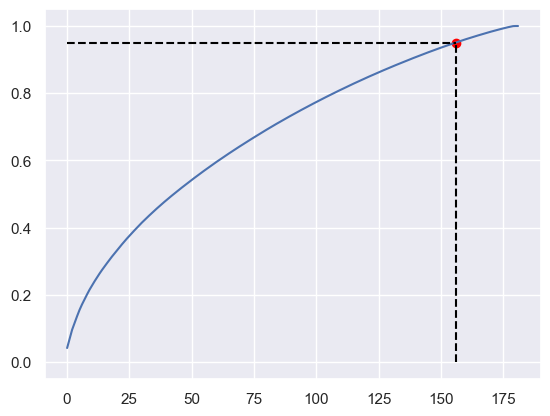

In [19]:
pca = PCA()
pca_array = pca.fit_transform(df_dim_red)
pca_array_df = pd.DataFrame(pca_array, columns=[f'PC{i+1}' for i in range(pca_array.shape[1])], index=df_dim_red.index)
merged_pca_array_df = pd.merge(pca_array_df, df_metaH['Condition'], left_index=True, right_index=True)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
nec_dimensions = np.argmax(cumsum >= 0.95)
plt.scatter(nec_dimensions, 0.95, color='red')
plt.plot([nec_dimensions, nec_dimensions], [0, 0.95], linestyle='--', color='black')
plt.plot([0, nec_dimensions], [0.95, 0.95], linestyle='--', color='black')
print(f"The number of dimensions needed to explain 95% of the variance is {nec_dimensions}")

In [20]:
# we now use pca to visualize the data
three_dim_df = merged_pca_array_df[['PC1', 'PC2', 'PC3', 'Condition']]
three_dim_df.head()

,PC1,PC2,PC3,Condition
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-2.849172,-5.641256,3.283657,Normo
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,7.899027,10.434396,-8.601802,Hypo
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,-0.497909,12.686548,-9.234080,Hypo
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,4.081950,8.070230,-4.739527,Hypo
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,2.255481,2.840024,-4.790213,Hypo


In [21]:
import plotly.express as px

fig = px.scatter_3d(
    data_frame = three_dim_df,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    title="3-dimensional representation of the data with UMAP",
    color = "Condition"
)
# Show the fig
fig.show()

UMAP

In [22]:
import umap.umap_ as umap

n_neighbors_list = [2, 10, 50, df_dim_red.shape[0]-1]

umap_dict = {}
for n in n_neighbors_list:
    reducer = umap.UMAP(n_components=3, n_neighbors=n)
    embedding = reducer.fit_transform(df_dim_red)
    columns = [f'UMAP{i+1}' for i in range(embedding.shape[1])]
    umap_embedding_df = pd.DataFrame(embedding, columns=columns, index=df_dim_red.index)
    merged_umap = pd.merge(umap_embedding_df, df_metaH['Condition'], left_index=True, right_index=True)
    merged_umap['n_neighbors'] = [n]*df_dim_red.shape[0]
    umap_dict[n] = merged_umap
    
    fig = px.scatter_3d(
    data_frame = merged_umap,
    x = "UMAP1",
    y = "UMAP2",
    z = "UMAP3",
    title=f"3-dimensional representation of the data with UMAP, n_neighbors = {n}",
    color = "Condition"
    )
    fig.show()